## Load environment data

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os

## Model Configuration

In [2]:
from langchain_groq import ChatGroq
model=ChatGroq(model="gemma2-9b-it")

## Embedding model Configuration

In [3]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

C:\Users\User\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Llama pdf

In [4]:
from langchain.document_loaders import PyPDFLoader
loader = PyPDFLoader("C:/Users/User/Desktop/AgenticAI2/data/llama2.pdf")
llama_documents = loader.load()

### Chunk using RecursiveTextCharacter spliter

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
    separators=["\n\n", "\n", ".", " ",""],
)
llama_chunk_docs=text_splitter.split_documents(llama_documents)

### Add data into Chroma vector DB

In [6]:
from langchain_community.vectorstores import Chroma
db=Chroma.from_documents(llama_chunk_docs,embeddings)

In [162]:
retriever=db.as_retriever(search_kwargs={"k":3})

In [163]:
retriever.invoke("llama model details ?")

[Document(metadata={'producer': 'pdfTeX-1.40.25', 'author': '', 'creationdate': '2023-07-20T00:30:36+00:00', 'moddate': '2023-07-20T00:30:36+00:00', 'total_pages': 77, 'page_label': '77', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'subject': '', 'trapped': '/False', 'page': 76, 'keywords': '', 'creator': 'LaTeX with hyperref', 'source': 'C:/Users/User/Desktop/AgenticAI2/data/llama2.pdf', 'title': ''}, page_content='Status This is a static model trained on an offline dataset. Future versions of the tuned\nmodels will be released as we improve model safety with community feedback.\nLicense A custom commercial license is available at:ai.meta.com/resources/\nmodels-and-libraries/llama-downloads/\nWhere to send com-\nments\nInstructions on how to provide feedback or comments on the model can be\nfound in the model README, or by opening an issue in the GitHub repository\n(https://github.com/facebookresearch/llama/).'),
 Docume

In [281]:
from pydantic import BaseModel, Field
from typing import TypedDict, Annotated, Sequence

class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="Selected topic")
    Details:str=Field(description="Details of selected topic")

In [282]:
from langchain.output_parsers import PydanticOutputParser
parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "Selected topic", "title": "Topic", "type": "string"}, "Details": {"description": "Details of selected topic", "title": "Details", "type": "string"}}, "required": ["Topic", "Details"]}\n```'

In [283]:
from langchain_core.messages import BaseMessage
import operator
from typing import TypedDict, Sequence, Annotated, List

class AgentState(TypedDict):
    messages: List[str]

In [284]:
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage

In [285]:
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import AIMessage

def supervisorNode(state: AgentState):
    input_query = state["messages"][-1]
    print("Input Query", input_query)

    template = """
Your task is to classify the given user input query into one of the following categories: [LLAMA_BASED_INPUT_QUERY, LATEST_DETAILS_INPUT_QUERY, YOUTUBE_VIDEOS_INPUT_QUERY, NOT_RELATED].
Respond using the following JSON format:
{format_instructions}
User input query: {input_query}
"""

    prompt = PromptTemplate(
        template=template,
        input_variables=["input_query"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    chain = prompt | model | parser
    supervisor_node_response = chain.invoke({"input_query": input_query})

    return {
        "messages": [
            input_query,
            supervisor_node_response.Topic,
        ]
    }


In [286]:
def supervisorRouterNode(state: AgentState) -> str:
    print("Router")
    classification = state["messages"][-1]
    print("Routing based on:", classification) 

    # Route based on content
    if classification == "LLAMA_BASED_INPUT_QUERY":
        return "LLAMA RAG CALL"
    elif classification == "LATEST_DETAILS_INPUT_QUERY":
        return "WEB SEARCH CALL"
    else:
        return "LLM CALL"


In [287]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [308]:
from langchain_core.output_parsers import StrOutputParser

In [310]:
def llama_rag_call(state: AgentState)->AgentState:
    print("LLAMA RAG CALL")
    question=state["messages"][-2]
    print("RAG question", question)
    promptData= PromptTemplate(
    template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
    input_variables=['context','question'])
    rag_chain=(
        {"context":retriever | format_docs, "question": RunnablePassthrough() }
        | promptData
        | model
        | StrOutputParser()
    )
    state["messages"].append(question)
    result=rag_chain.invoke(question)
    state["messages"].append(result)
    return state


In [311]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

def web_search_call(state: AgentState)-> AgentState:
    print("WEB SEARCH CALL")
    question=state["messages"][-2]
    print("question", question)
    api_wrapper=WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=700)
    wikiTool=WikipediaQueryRun(api_wrapper=api_wrapper)
    result= wikiTool.invoke({"query":question})
    state["messages"].append(question)
    results =[]
    results.append(result)
    state["messages"].append(result)
    return state


In [312]:
from langchain_community.tools import YouTubeSearchTool
def youtube_search_call(state: AgentState):
    print("YOUTUBE SEARCH CALL")
    question=state["messages"][-2]
    print("question", question)
    tool=YouTubeSearchTool()
    result=tool.invoke(question)
    return result

In [313]:
def llm_call(state: AgentState):
    print("LLMCALL")
    question=state["messages"][-2]
    print("question", question)
   
    result= model.invoke(question)
    print(result)
    state["messages"].append(question)
    state["messages"].append(result.content)
    return state

In [294]:
from langgraph.graph import StateGraph, END

In [314]:

workflow=StateGraph(AgentState)

In [315]:
workflow.add_node("Supervisor", supervisorNode)
workflow.add_node("Llama Rag Call", llama_rag_call)
workflow.add_node("Web Search Call", web_search_call)
#workflow.add_node("Youtube Search Call", youtube_search_call)
workflow.add_node("Llm Call", llm_call)




def validate_response(state: AgentState):
    print("Validator")
    response = state["messages"][0]
    print("Diljish_1",response)

    is_valid = True
    if isinstance(response, str):
        resp = response
    elif hasattr(response, "content"):
        resp = response.content
    else:
        resp = str(response)

    print("resp", resp)

    if not resp.strip() or resp.lower() in {"i don't know.", "not related", "not sufficient", "no data", "not available"}:
        is_valid = False

    state["validation_result"] = "PASS" if is_valid else "FAIL"
    return state


workflow.add_node("Validator", validate_response)

In [316]:

workflow.set_entry_point("Supervisor")

In [317]:
workflow.add_conditional_edges(
    "Supervisor",
    supervisorRouterNode,
    {
        "LLAMA RAG CALL": "Llama Rag Call",
        "WEB SEARCH CALL": "Web Search Call",
       # "YOUTUBE SEARCH CALL": "Youtube Search Call",
        "LLM CALL": "Llm Call",
    }
)

In [318]:
def input_validation_node(state: AgentState) -> AgentState:
    print("VALIDATION NODE")

    result = state["messages"][-1]
    print("result", result)
    query= state["messages"][-2]
    print("query", query)
    print("Validating query:", query)
   
    if len(query.strip()) < 5:
        return {
            "messages": state["messages"] + ["INVALID_INPUT"]
        }

    return {
        "messages": state["messages"] + ["VALID_INPUT"]
    }


In [319]:
def validation_router_node(state: AgentState) -> str:
    print("VALIDATION ROUTER")
    validation_result = state["messages"][-1]
    print("Test", state["messages"][-2])
    if "Please provide me with more context" in state["messages"][-2]:
        validation_result= "INVALID_INPUT"
    if validation_result == "VALID_INPUT":
        return "Exit"
    
    print("Test4", state["messages"][-4])
    print("Test3", state["messages"][-3])
    state["messages"].append(state["messages"][-3])
    print(state["messages"][-4])
    return "Fallback"


In [320]:
workflow.add_conditional_edges(
    "Validation",
    validation_router_node,
    {
        "Fallback": "Fallback",
        "Exit": END
    }
)

In [321]:
def fallback_node(state: AgentState) -> AgentState:
    question=state["messages"][-1]
    
    result_from_model=model.invoke(question)
    rag_docs = retriever.invoke(question)
    rag_result = "\n\n".join(doc.page_content for doc in rag_docs)

    return {
        "messages": state["messages"] + [result_from_model.content, rag_result]
    }


In [322]:
workflow.add_node("Validation", input_validation_node)
workflow.add_node("Fallback", fallback_node)

workflow.add_edge("Llama Rag Call", "Validation")
workflow.add_edge("Web Search Call", "Validator")
workflow.add_edge("Youtube Search Call", "Validator")
workflow.add_edge("Llm Call", "Validator")

In [323]:
workflow.add_edge("Llama Rag Call", "Validation")
workflow.add_edge("Web Search Call", "Validation")
#workflow.add_edge("Youtube Search Call", END)
workflow.add_edge("Llm Call", "Validation")
workflow.add_edge("Fallback", END)


def validatorRouter(state: AgentState):
    print(state["messages"])
    result = state.get("validation_result")
    print ("DDDD", result)
    return "PASS" if result == "PASS" else "FAIL"

workflow.add_conditional_edges(
    "Validator",
    validatorRouter,
    {
        "PASS" : END,
        "FAIL" : "Supervisor"
    }
)

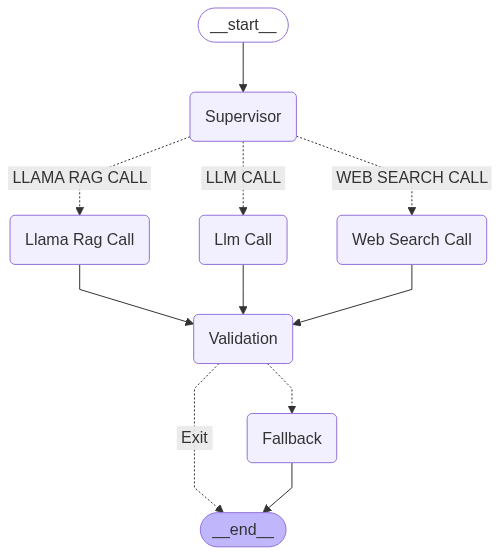

In [324]:
workflow.compile()

In [325]:
app=workflow.compile()

In [326]:
state = {"messages": ["what is what"]}

In [327]:
app.invoke(state)

Input Query what is what
Router
Routing based on: NOT_RELATED
LLMCALL
question what is what
content='Please rephrase your question! \n\n"What is what" doesn\'t give me enough information to understand what you\'re asking. \n\nFor example, you could ask:\n\n* **"What is the capital of France?"**\n* **"What is the meaning of life?"**\n* **"What is your favorite color?"**\n\n\nLet me know what you\'d like to know, and I\'ll do my best to help! 😊 \n' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 99, 'prompt_tokens': 12, 'total_tokens': 111, 'completion_time': 0.18, 'prompt_time': 0.001909846, 'queue_time': 0.241536404, 'total_time': 0.181909846}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None} id='run--3a137ea1-159e-404d-857b-3c2baca4a999-0' usage_metadata={'input_tokens': 12, 'output_tokens': 99, 'total_tokens': 111}
VALIDATION NODE
result Please rephrase your question! 

"What is what" doesn't 

{'messages': ['what is what',
  'NOT_RELATED',
  'what is what',
  'Please rephrase your question! \n\n"What is what" doesn\'t give me enough information to understand what you\'re asking. \n\nFor example, you could ask:\n\n* **"What is the capital of France?"**\n* **"What is the meaning of life?"**\n* **"What is your favorite color?"**\n\n\nLet me know what you\'d like to know, and I\'ll do my best to help! 😊 \n',
  'VALID_INPUT']}

In [328]:
state = {"messages": ["what is llama2 model"]}
app.invoke(state)

Input Query what is llama2 model
Router
Routing based on: LLAMA_BASED_INPUT_QUERY
LLAMA RAG CALL
RAG question what is llama2 model
VALIDATION NODE
result Llama 2 is a new large language model (LLM) released by Meta.  It is a static model trained on a dataset that is no longer being updated. Llama 2 has been tested primarily in English and may produce inaccurate or objectionable responses. 

query what is llama2 model
Validating query: what is llama2 model
VALIDATION ROUTER
Test Llama 2 is a new large language model (LLM) released by Meta.  It is a static model trained on a dataset that is no longer being updated. Llama 2 has been tested primarily in English and may produce inaccurate or objectionable responses. 



{'messages': ['what is llama2 model',
  'LLAMA_BASED_INPUT_QUERY',
  'what is llama2 model',
  'Llama 2 is a new large language model (LLM) released by Meta.  It is a static model trained on a dataset that is no longer being updated. Llama 2 has been tested primarily in English and may produce inaccurate or objectionable responses. \n',
  'VALID_INPUT']}

In [329]:
state = {"messages": ["cristiano youtube channle"]}
app.invoke(state)

Input Query cristiano youtube channle
Router
Routing based on: YOUTUBE_VIDEOS_INPUT_QUERY
LLMCALL
question cristiano youtube channle
content="Cristiano Ronaldo has an official YouTube channel! \n\nYou can find it here:  **https://www.youtube.com/cristiano** \n\nOn his channel, you'll find a variety of content, including:\n\n* **Behind-the-scenes footage:** Get a glimpse into Ronaldo's life on and off the field.\n* **Training highlights:** Watch Ronaldo's intense workouts and skills.\n* **Interviews and Q&As:** Hear from Ronaldo himself about his career, inspirations, and more.\n* **Match highlights and reactions:** See Ronaldo's best moments from his matches and his reactions to them.\n* **Family and lifestyle content:** Get to know Ronaldo's family and see how he spends his time away from football.\n\n\nLet me know if you have any other questions! \n" additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 171, 'prompt_tokens': 15, 'total_tokens': 186, 'completion

{'messages': ['cristiano youtube channle',
  'YOUTUBE_VIDEOS_INPUT_QUERY',
  'cristiano youtube channle',
  "Cristiano Ronaldo has an official YouTube channel! \n\nYou can find it here:  **https://www.youtube.com/cristiano** \n\nOn his channel, you'll find a variety of content, including:\n\n* **Behind-the-scenes footage:** Get a glimpse into Ronaldo's life on and off the field.\n* **Training highlights:** Watch Ronaldo's intense workouts and skills.\n* **Interviews and Q&As:** Hear from Ronaldo himself about his career, inspirations, and more.\n* **Match highlights and reactions:** See Ronaldo's best moments from his matches and his reactions to them.\n* **Family and lifestyle content:** Get to know Ronaldo's family and see how he spends his time away from football.\n\n\nLet me know if you have any other questions! \n",
  'VALID_INPUT']}